In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import s3fs
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
from read_pangeo import read_pangeo, read_to_detect
from importcmip import aod245, aodh, aod585, read_370
#from aod_correction import bias_correction

In [8]:
from aod_correction import bias_correction
# perform bias correction for aerosol data
histo = aodh['od550aer'].values
ssp245 = aod245['od550aer'].values
ssp585 = aod585['od550aer'].values
b245 = bias_correction(histo,ssp245, '245')
b585 = bias_correction(histo,ssp585, '585')

aodh['od550aer'] = (['time','lat','lon'], b245[0])
aod245['od550aer'] = (['time','lat','lon'], b245[1])
aod585['od550aer'] = (['time','lat','lon'], b585[1])

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5647: RuntimeWarning: divide by zero encountered in divide
  return pow(qsk/(1.0-qsk), 1.0/s)
/home/jovyan/Tjaernoe2022-group5/notebooks/Lea/aod_correction.py:42: RuntimeWarning: invalid value encountered in multiply
  loc_pm = delta_loc*loc_qm


In [9]:
#load and merge data
arh = xr.open_dataset('historical20002014_AR_detection.nc')
ar245 = xr.open_dataset('ssp24520852100_AR_detection.nc')
ar370 = xr.open_dataset('ssp37020852099_AR_detection.nc')
ar585 = xr.open_dataset('ssp58520852100_AR_detection.nc')

cmh = read_pangeo(2000, 2014, 'historical')
dh = cmh.merge(aodh.drop(['lat_bnds', 'time_bnds', 'lon_bnds']))

cm245 = read_pangeo(2085, 2099, 'ssp245')
d245= cm245.merge(aod245.drop(['lat_bnds', 'time_bnds', 'lon_bnds']))

cm585 = read_pangeo(2085, 2099, 'ssp585')
d585 = cm585.merge(aod585.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
# loading ssp370 is more of a hussle, therefore reading in the data looks weirder
import s3fs
start_year = 2085
end_year = 2099

cm370 = read_pangeo(2085, 2099, 'ssp370')

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3path = list([
        'escience2022/Remy/od550aer_AERday_NorESM2-LM_ssp370_r1i1p1f1_gn_20810101-20901231.nc',
        'escience2022/Remy/od550aer_AERday_NorESM2-LM_ssp370_r1i1p1f1_gn_20910101-21001231.nc',
        'escience2022/Remy/va_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20810101-20901231.nc',
        'escience2022/Remy/va_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20910101-21001231.nc',
        'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20810101-20901231.nc',
        'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20910101-21001231.nc',
    ])
sopenlist=[s3.open(ss) for ss in s3path]
cm370b  = (xr.open_mfdataset(sopenlist)).sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))

# correct aod
ssp370 = cm370b['od550aer'].values
b370 = bias_correction(histo,ssp370, '370') 
cm370b['od550aer'] = (['time','lat','lon'], b370[1])

d370 = cm370.merge(cm370b.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))


#ssp370 = d370['od550aer'].values.flatten()
'''b370 = bias_correction(histo,ssp370)'''


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


'b370 = bias_correction(histo,ssp370)'

In [15]:
cm585 = read_pangeo(2085, 2099, 'ssp585')
d585 = cm585.merge(aod585.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [51]:
'''n245 = d245.sel(lat = slice(50,90),plev=slice(100000, 25000))
masked_n245 = n245.where(ar245['ivt']==True)
neg_n245 = n245.where(ar245['ivt']==False)
na245 = masked_n245['od550aer'].values.flatten() 
na245 = na245[~np.isnan(na245)]'''

In [16]:
# slice to poles and only until pressure levels where AR can be detected
n245 = d245.sel(lat = slice(50,90),plev=slice(100000, 25000))
s245 =d245.sel(lat = slice(-90,-50),plev=slice(100000, 25000))

n370 = d370.sel(lat = slice(50,90),plev=slice(100000, 25000))
s370 =d370.sel(lat = slice(-90,-50),plev=slice(100000, 25000))

n585 = d585.sel(lat = slice(50,90),plev=slice(100000, 25000))
s585 =d585.sel(lat = slice(-90,-50),plev=slice(100000, 25000))

nh = dh.sel(lat = slice(50,90), plev=slice(100000, 25000))
sh =dh.sel(lat = slice(-90,-50), plev=slice(100000, 25000))


# mask data for being inside or outside of a atmospheric river
# arctic
masked_n245 = n245.where(ar245['ivt']==True)
masked_n370 = n370.where(ar370['ivt']==True)
masked_n585 = n585.where(ar585['ivt']==True)
masked_nh = nh.where(arh['ivt']==True)

neg_n245 = n245.where(ar245['ivt']==False)
neg_n370 = n370.where(ar370['ivt']==False)
neg_n585 = n585.where(ar585['ivt']==False)
neg_nh = nh.where(arh['ivt']==False)

# antarctic
masked_s245 = s245.where(ar245['ivt']==True)
masked_s370 = s370.where(ar370['ivt']==True)
masked_s585 = s585.where(ar585['ivt']==True)
masked_sh = sh.where(arh['ivt']==True)

neg_s245 = s245.where(ar245['ivt']==False)
neg_s370 = s370.where(ar370['ivt']==False)
neg_s585 = s585.where(ar585['ivt']==False)
neg_sh = sh.where(arh['ivt']==False)

In [17]:
#treat variables for plotting
#integrate needed humidity
int_nh245 =-1*masked_n245['hus'].integrate('plev')
int_sh245 =-1*masked_s245['hus'].integrate('plev')
int_nh370 =-1*masked_n370['hus'].integrate('plev')
int_sh370 =-1*masked_s370['hus'].integrate('plev')
int_nh585 =-1*masked_n585['hus'].integrate('plev')
int_sh585 =-1*masked_s585['hus'].integrate('plev')
int_nhh =-1*masked_nh['hus'].integrate('plev')
int_shh =-1*masked_sh['hus'].integrate('plev')

# for plotting with matplotlib: flatten db to array 
int_nh245 = int_nh245.values.flatten() 
int_sh245 = int_sh245.values.flatten()
int_nh370 = int_nh370.values.flatten()
int_sh370 = int_sh370.values.flatten()
int_nh585 = int_nh585.values.flatten()
int_sh585 = int_sh585.values.flatten()
int_nhh = int_nhh.values.flatten()
int_shh = int_shh.values.flatten()
# remove na from dataset to be able to weight distribution
int_nh245 = int_nh245[~np.isnan(int_nh245)]
int_sh245 = int_sh245[~np.isnan(int_sh245)]
int_nh370 = int_nh370[~np.isnan(int_nh370)]
int_sh370 = int_sh370[~np.isnan(int_sh370)]
int_nh585 = int_nh585[~np.isnan(int_nh585)]
int_sh585 = int_sh585[~np.isnan(int_sh585)]
int_nhh = int_nhh[~np.isnan(int_nhh)]
int_shh = int_shh[~np.isnan(int_shh)]

In [ ]:
import scipy
from scipy.stats import wilcoxon
import random

nh370sized = int_nh370[np.random.randint(0, len(int_nh370), 10000)]
nh245sized = int_nh245[np.random.randint(0, len(int_nh245), 10000)]
nh585sized = int_nh585[np.random.randint(0, len(int_nh585), 10000)]
nhhsized =int_nhh[np.random.randint(0, len(int_nhh), 10000)]
print(len(nh370sized),len(nh245sized), len(nh585sized), len(nhhsized))

#humidity wilcoxon test
whn245_370 = wilcoxon(nh245sized,nh370sized)
whn245_585 = wilcoxon(nh245sized,nh585sized)
whn245_nh = wilcoxon(nh245sized,nhhsized)
whn370_585 = wilcoxon(nh370sized,nh585sized)
whn370_nh = wilcoxon(nh370sized,nhhsized)
whn585_nh = wilcoxon(nh585sized,nhhsized)

np.array([whn245_370,whn245_585,whn245_nh,whn370_585,whn370_nh,whn585_nh])


In [19]:
#treat variables for plotting
# AOD
# for plotting with matplotlib: flatten db to array 
na245 = masked_n245['od550aer'].values.flatten() 
sa245 = masked_s245['od550aer'].values.flatten()
na370 = masked_n370['od550aer'].values.flatten()
sa370 = masked_s370['od550aer'].values.flatten()
na585 = masked_n585['od550aer'].values.flatten()
sa585 = masked_s585['od550aer'].values.flatten()
nah = masked_nh['od550aer'].values.flatten()
sah = masked_sh['od550aer'].values.flatten()

# remove na from dataset to be able to weight distribution
na245 = na245[~np.isnan(na245)]
sa245 = sa245[~np.isnan(sa245)]
na370 = na370[~np.isnan(na370)]
sa370 = sa370[~np.isnan(sa370)]
na585 = na585[~np.isnan(na585)]
sa585 = sa585[~np.isnan(sa585)]
nah = nah[~np.isnan(nah)]
sah = sah[~np.isnan(sah)]

In [177]:
# AOD wilcoxon test
na370sized = na370[np.random.randint(0, len(na370), 10000)]
na245sized = na245[np.random.randint(0, len(na245), 10000)]
na585sized = na585[np.random.randint(0, len(na585), 10000)]
nahsized = nah[np.random.randint(0, len(nah), 10000)]

print(len(na370sized),len(na245sized), len(na585sized), len(nahsized))

wan245_370 = wilcoxon(na245sized,na370sized)
wan245_585 = wilcoxon(na245sized,na585sized)
wan245_na = wilcoxon(na245sized, nahsized)
wan370_585 = wilcoxon(na370sized,na585sized)
wan370_na = wilcoxon(na370sized, nahsized)
wan585_na = wilcoxon(na585sized, nahsized)

np.array([wan245_370,wan245_585,wan245_na,wan370_585,wan370_na,wan585_na])


10000 10000 10000 10000


array([[2.03915040e+007, 2.01029725e-057],
       [2.12349005e+007, 6.32405730e-039],
       [1.76634055e+007, 1.46049955e-142],
       [2.38869730e+007, 1.11541071e-004],
       [2.21073955e+007, 1.14604907e-023],
       [2.10705920e+007, 3.06628976e-042]])

In [181]:
# precipitation wilcoxon test
np370sized = np370[np.random.randint(0, len(np370), 10000)]
np245sized = np245[np.random.randint(0, len(np245), 10000)]
np585sized = np585[np.random.randint(0, len(np585), 10000)]
nphsized = nph[np.random.randint(0, len(nph), 10000)]

print(len(na370sized),len(na245sized), len(na585sized), len(nahsized))

wpn245_370 = wilcoxon(np245sized,np370sized)
wpn245_585 = wilcoxon(np245sized,np585sized)
wpn245_na = wilcoxon(np245sized, nphsized)
wpn370_585 = wilcoxon(np370sized,np585sized)
wpn370_np = wilcoxon(np370sized, nphsized)
wpn585_np = wilcoxon(np585sized, nphsized)

np.array([wpn245_370,wpn245_585,wpn245_na,wpn370_585,wpn370_np,wpn585_np])

10000 10000 10000 10000


array([[2.42223150e+07, 6.88331372e-03],
       [2.46405020e+07, 2.09876969e-01],
       [2.40916675e+07, 1.60509266e-03],
       [2.46710625e+07, 2.50949130e-01],
       [2.34857700e+07, 1.49063252e-07],
       [2.36951915e+07, 5.94573480e-06]])

In [54]:
#treat variables for plotting
# precipitation
# for plotting with matplotlib: flatten db to array 
np245 = masked_n245['pr'].values.flatten() 
sp245 = masked_s245['pr'].values.flatten()
np370 = masked_n370['pr'].values.flatten()
sp370 = masked_s370['pr'].values.flatten()
np585 = masked_n585['pr'].values.flatten()
sp585 = masked_s585['pr'].values.flatten()
nph = masked_nh['pr'].values.flatten()
sph = masked_sh['pr'].values.flatten()

# remove na from dataset to be able to weight distribution
np245 = np245[~np.isnan(np245)]
sp245 = sp245[~np.isnan(sp245)]
np370 = np370[~np.isnan(np370)]
sp370 = sp370[~np.isnan(sp370)]
np585 = np585[~np.isnan(np585)]
sp585 = sp585[~np.isnan(sp585)]
nph = nph[~np.isnan(nph)]
sph = sph[~np.isnan(sph)]



np245 =np245[np245 >0.0000024099]
sp245=sp245[sp245>0.0000024099]
np370=np370[np370>0.0000024099]
sp370=sp370[sp370>0.0000024099]
np585=np585[np585>0.0000024099]
sp585=sp585[sp585>0.0000024099]
nph =nph[nph >0.0000024099]
sph=sph[sph>0.0000024099]

np245= np245*60*60*24
sp245= sp245*60*60*24
np370= np370*60*60*24
sp370= sp370*60*60*24
np585= np585*60*60*24
sp585= sp585 *60*60*24
nph= nph*60*60*24
sph= sph*60*60*24



In [49]:
#treat variables for plotting
# surface temperature
avtn245 = n245['tas'].mean(['time','lat','lon'])
avts245 = s245['tas'].mean(['time','lat','lon'])

avtn370 = n370['tas'].mean(['time','lat','lon'])
avts370 = s370['tas'].mean(['time','lat','lon'])

avtn585 = n585['tas'].mean(['time','lat','lon'])
avts585 = s585['tas'].mean(['time','lat','lon'])

avtnh =nh['tas'].mean(['time','lat','lon'])
avtsh = sh['tas'].mean(['time','lat','lon'])

# for plotting with matplotlib: flatten db to array and substract average
nt245 = (n245['tas']-avtn245).values.flatten() 
st245 = (s245['tas']-avts245).values.flatten()
nt370 = (n370['tas']-avtn370).values.flatten()
st370 = (s370['tas']-avts370).values.flatten()
nt585 = (n585['tas']-avtn585).values.flatten()
st585 = (s585['tas']-avts585).values.flatten()
nth = (nh['tas']-avtnh).values.flatten()
sth = (sh['tas']-avtsh).values.flatten()

# remove na from dataset to be able to weight distribution
nt245 = nt245[~np.isnan(nt245)]
st245 = st245[~np.isnan(st245)]
nt370 = nt370[~np.isnan(nt370)]
st370 = st370[~np.isnan(st370)]
nt585 = nt585[~np.isnan(nt585)]
st585 = st585[~np.isnan(st585)]
nth = nth[~np.isnan(nth)]
tph = sth[~np.isnan(sth)]

KeyboardInterrupt: 

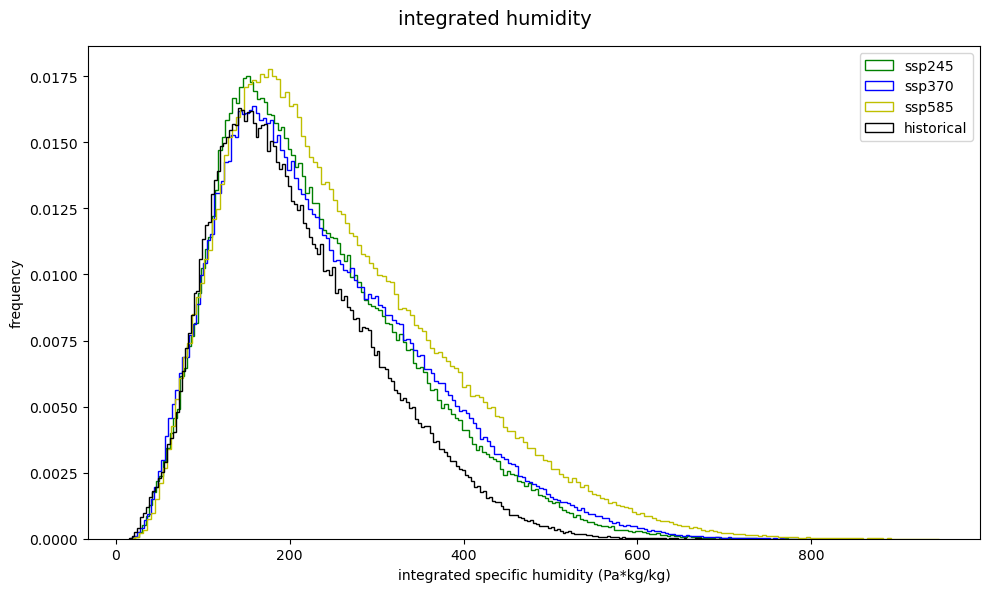

In [28]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('integrated humidity', fontsize=14)

axs.hist(int_nh245, weights = np.zeros_like(int_nh245)+1./int_nh245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs.hist(int_nh370, weights = np.zeros_like(int_nh370)+1./int_nh370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs.hist(int_nh585, weights = np.zeros_like(int_nh585)+1./int_nh585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs.hist(int_nhh, weights = np.zeros_like(int_nhh)+1./int_nhh.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs.legend() 
axs.set( xlabel = 'integrated specific humidity (Pa*kg/kg)', ylabel = 'frequency')
plt.tight_layout()

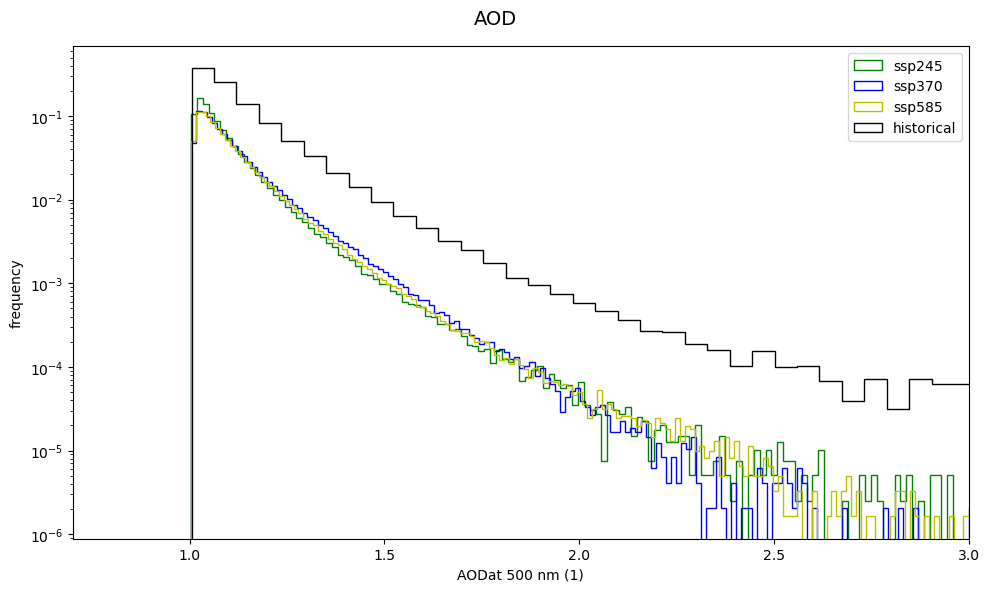

In [62]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('AOD', fontsize=14)

axs.hist(na245, weights = np.zeros_like(na245)+1./na245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200, )
axs.hist(na370, weights = np.zeros_like(na370)+1./na370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200,)
axs.hist(na585, weights = np.zeros_like(na585)+1./na585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200, )
axs.hist(nah, weights = np.zeros_like(nah)+1./nah.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200, )
axs.legend() 
axs.set(xlim = (0.7,3), yscale = 'log', xlabel = 'AODat 500 nm (1)', ylabel = 'frequency')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('Precipitation', fontsize=14)

axs.hist(np245, weights = np.zeros_like(np245)+1./np245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 70)
axs.hist(np370, weights = np.zeros_like(np370)+1./np370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 70)
axs.hist(np585, weights = np.zeros_like(np585)+1./np585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 70)
axs.hist(nph, weights = np.zeros_like(nph)+1./nph.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 70)
axs.legend() 
axs.set(yscale = 'log', xlabel = 'Precipitation in mm/s', ylabel = 'frequency')
plt.tight_layout()

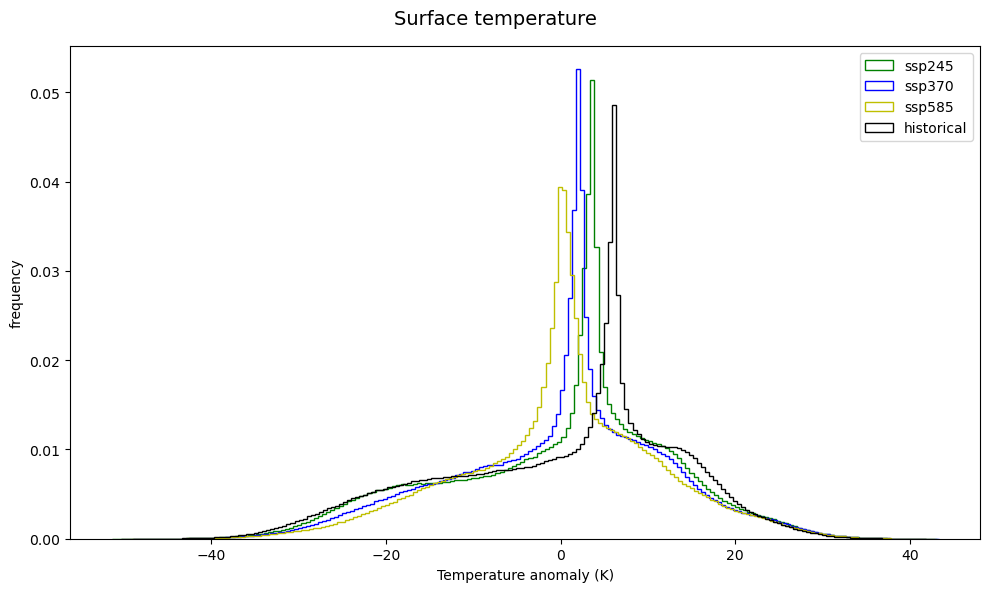

In [91]:
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('Surface temperature', fontsize=14)

axs.hist(nt245, weights = np.zeros_like(nt245)+1./nt245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs.hist(nt370, weights = np.zeros_like(nt370)+1./nt370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs.hist(nt585, weights = np.zeros_like(nt585)+1./nt585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs.hist(nth, weights = np.zeros_like(nth)+1./nth.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs.legend() 
axs.set(xlabel = 'Temperature anomaly (K)', ylabel = 'frequency')
plt.tight_layout()

In [ ]:
'''fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('integrated humidity', fontsize=16)

axs.hist(int_nh245, weights = np.zeros_like(int_nh245)+1./int_nh245.size, 
       alpha = 0.5, color = "g", label = "ssp245", bins=np.logspace(np.log10(int_nh245.min()),np.log10(int_nh245.max()),30))
axs.hist(int_nh370, weights = np.zeros_like(int_nh370)+1./int_nh370.size, 
       alpha = 0.3, color = "b", label = "ssp370", bins=np.logspace(np.log10(int_nh370.min()),np.log10(int_nh370.max()),30))
axs.hist(int_nh585, weights = np.zeros_like(int_nh585)+1./int_nh585.size, 
          alpha = 0.5, color = "y", label = "ssp585", bins=np.logspace(np.log10(int_nh585.min()),np.log10(int_nh585.max()),30))
axs.hist(int_nhh, weights = np.zeros_like(int_nhh)+1./int_nhh.size, 
       alpha = 0.2, color = "k", label = "historical", bins=np.logspace(np.log10(int_nhh.min()),np.log10(int_nhh.max()),30))
axs.legend() 
axs.set(xscale = 'log',  xlabel = 'integrated specific humidity (Pa*kg/kg)', ylabel = 'frequency')'''

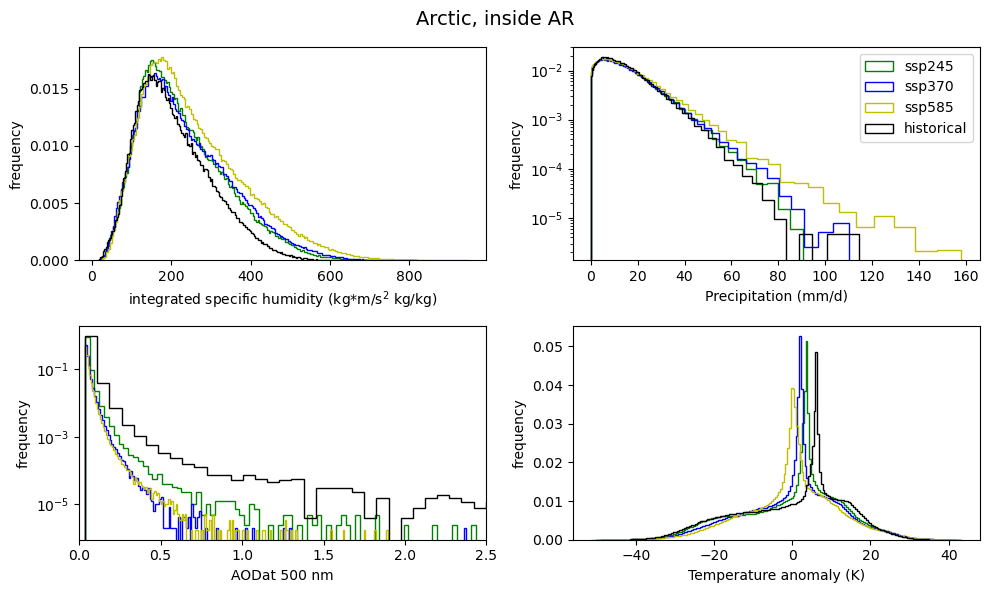

In [55]:
fig, axs = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Arctic, inside AR', fontsize=14)
axs = axs.flatten()
axs[0].hist(int_nh245, weights = np.zeros_like(int_nh245)+1./int_nh245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs[0].hist(int_nh370, weights = np.zeros_like(int_nh370)+1./int_nh370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs[0].hist(int_nh585, weights = np.zeros_like(int_nh585)+1./int_nh585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs[0].hist(int_nhh, weights = np.zeros_like(int_nhh)+1./int_nhh.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs[0].set( xlabel = 'integrated specific humidity (kg*m/s$^2$ kg/kg)', ylabel = 'frequency')

axs[1].hist(np245, weights = np.zeros_like(np245)+1./np245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins=np.logspace(np.log10(np245.min()),np.log10(np245.max()),100))
axs[1].hist(np370, weights = np.zeros_like(np370)+1./np370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins=np.logspace(np.log10(np370.min()),np.log10(np370.max()),100))
axs[1].hist(np585, weights = np.zeros_like(np585)+1./np585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins=np.logspace(np.log10(np585.min()),np.log10(np585.max()),100))
axs[1].hist(nph, weights = np.zeros_like(nph)+1./nph.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins=np.logspace(np.log10(nph.min()),np.log10(nph.max()),100)) 
axs[1].set(yscale ='log', xlabel = 'Precipitation (mm/d)', ylabel = 'frequency')
axs[1].legend() 

axs[2].hist(na245, weights = np.zeros_like(na245)+1./na245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200, )
axs[2].hist(na370, weights = np.zeros_like(na370)+1./na370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200,)
axs[2].hist(na585, weights = np.zeros_like(na585)+1./na585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200, )
axs[2].hist(nah, weights = np.zeros_like(nah)+1./nah.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200, )
axs[2].set( xlim = (0,2.5), xlabel = 'AODat 500 nm', ylabel = 'frequency', yscale = 'log')

axs[3].hist(nt245, weights = np.zeros_like(nt245)+1./nt245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs[3].hist(nt370, weights = np.zeros_like(nt370)+1./nt370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs[3].hist(nt585, weights = np.zeros_like(nt585)+1./nt585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs[3].hist(nth, weights = np.zeros_like(nth)+1./nth.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs[3].set(xlabel = 'Temperature anomaly (K)', ylabel = 'frequency')
plt.tight_layout()
plt.savefig('Arctic_future.png')

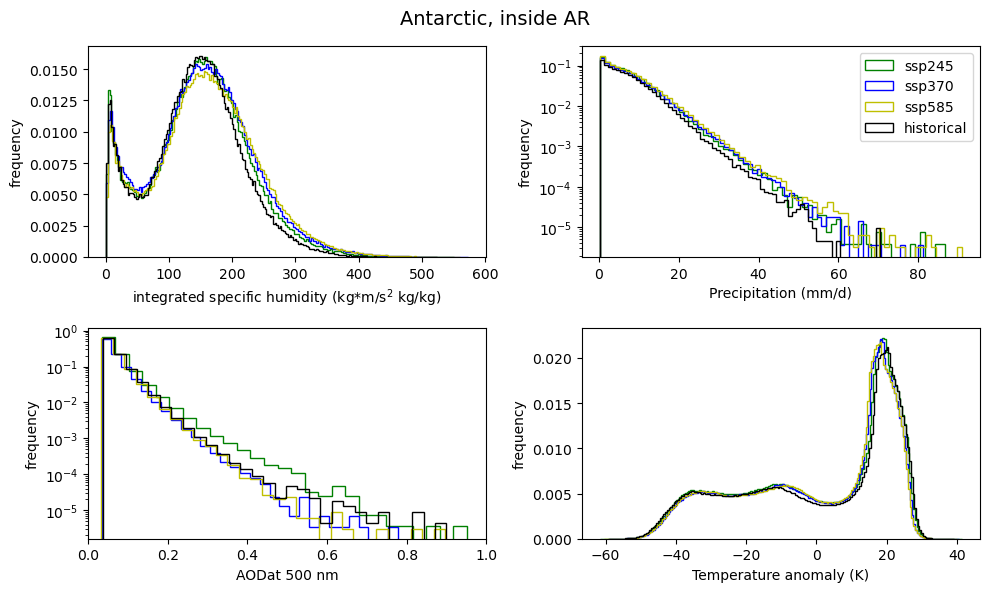

In [53]:
fig, axs = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Antarctic, inside AR', fontsize=14)
axs = axs.flatten()
axs[0].hist(int_sh245, weights = np.zeros_like(int_sh245)+1./int_sh245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs[0].hist(int_sh370, weights = np.zeros_like(int_sh370)+1./int_sh370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs[0].hist(int_sh585, weights = np.zeros_like(int_sh585)+1./int_sh585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs[0].hist(int_shh, weights = np.zeros_like(int_shh)+1./int_shh.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs[0].set( xlabel = 'integrated specific humidity (kg*m/s$^2$ kg/kg)', ylabel = 'frequency')

axs[1].hist(sp245, weights = np.zeros_like(sp245)+1./sp245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 70)
axs[1].hist(sp370, weights = np.zeros_like(sp370)+1./sp370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 70)
axs[1].hist(sp585, weights = np.zeros_like(sp585)+1./sp585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 70)
axs[1].hist(sph, weights = np.zeros_like(sph)+1./sph.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 70) 
axs[1].set(yscale ='log', xlabel = 'Precipitation (mm/d)', ylabel = 'frequency')
axs[1].legend() 

axs[2].hist(sa245, weights = np.zeros_like(sa245)+1./sa245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 30, )
axs[2].hist(sa370, weights = np.zeros_like(sa370)+1./sa370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 30,)
axs[2].hist(sa585, weights = np.zeros_like(sa585)+1./sa585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 30, )
axs[2].hist(sah, weights = np.zeros_like(sah)+1./sah.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 30, )
axs[2].set(yscale = 'log', xlim = (0,1), xlabel = 'AODat 500 nm', ylabel = 'frequency')

axs[3].hist(st245, weights = np.zeros_like(st245)+1./nt245.size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs[3].hist(st370, weights = np.zeros_like(st370)+1./nt370.size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs[3].hist(st585, weights = np.zeros_like(st585)+1./nt585.size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs[3].hist(sth, weights = np.zeros_like(sth)+1./nth.size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs[3].set(xlabel = 'Temperature anomaly (K)', ylabel = 'frequency')
plt.tight_layout()
plt.savefig('Antarctic_future.png')

In [ ]:
'''# for frequency plots slice for plev >25000 and integrate over plev
mpl =marc.sel(plev=slice(100000, 25000))
pl =amarc.sel(plev=slice(100000, 25000)).where(arc['va'] > 0)

# wind
mplva =-1*mpl['va'].integrate('plev')
plva =-1*pl['va'].integrate('plev')

# humidity
mplh =-1*mpl['hus'].integrate('plev')
plh =-1*pl['hus'].integrate('plev')

mv = mplva.values.flatten()
mv = mv[~np.isnan(mv)]
v = plva.values.flatten()
v= v[~np.isnan(v)]
mh = mplh.values.flatten()
mh = mh[~np.isnan(mh)]
h = plh.values.flatten()
h = h[~np.isnan(h)]
mcc = pl['clt'].values.flatten()
mcc = mcc[~np.isnan(mcc)]
cc = mpl['clt'].values.flatten()
cc = cc[~np.isnan(cc)]
mt = mpl['tas'].values.flatten()
mt = mt[~np.isnan(mt)]
t = pl['tas'].values.flatten()
t = t[~np.isnan(t)]
ma = mpl['od550aer'].values.flatten()
ma = ma[~np.isnan(ma)]
a = pl['od550aer'].values.flatten()
a = a[~np.isnan(a)]
mp = mpl['pr'].values.flatten()
mp = mp[~np.isnan(mp)]
mp = mp[mp>0.0000024099]
p = pl['pr'].values.flatten()
p = p[~np.isnan(p)]
p = p[p>0.0000024099] # threshold for averaged precipitation in the sahara in the same unit'''

In [ ]:
a = n245['tas'].groupby('time.season')
b = n370['tas'].groupby('time.season')
c = n585['tas'].groupby('time.season')
d = nh['tas'].groupby('time.season')


fig, axs = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Surface temperature', fontsize=14)
axs = axs.flatten()

a.plot.hist(ax = axs[0],  
        fill = False, histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
b.plot.hist(ax =axs[1], 
        fill = False, histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
c.plot.hist(ax =axs[2],  
        fill = False,  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
d.plot.hist(ax =axs[3],  
        fill = False, histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs.set(xlabel = 'Temperature (K)', ylabel = 'frequency')
axs.legend() 
plt.tight_layout()